# Generative Adversarial Network

生成对抗网络包含了两个子网络：生成网络(Generator，简称G)和判别网络
(Discriminator，简称D)，其中生成网络G 负责学习样本的真实分布，判别网络D 负责将
生成网络采样的样本与真实样本区分开来。

In [10]:
import os
import glob

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

In [12]:
from dataset import make_anime_dataset

batch_size = 64
img_path = glob.glob(r'/home/ulysses/workspace/AI/Deep-Learning-with-TensorFlow-book/ch13/faces/*.jpg')
print('images num:', len(img_path))
dataset, img_shape, _ = make_anime_dataset(img_path, batch_size, resize=64)

images num: 51223


In [8]:
anime_path = glob.glob(r'/home/ulysses/workspace/AI/Deep-Learning-with-TensorFlow-book/ch13/faces/*.jpg')
print('image nums:', len(anime_path))

image nums: 51223


In [4]:
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import plot_model

In [5]:
def make_generator_model(z_dim):
    filters = 64
    model = tf.keras.Sequential([])
    
    model.add(layers.Reshape((1, 1, z_dim)))
    model.add(layers.ReLU())
    # 转置卷积-BN-激活函数:(b, 4, 4, 512)
    model.add(layers.Conv2DTranspose(filters=filters * 8, kernel_size=4, strides=1, padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    # 转置卷积-BN-激活函数:(b, 8, 8, 256)
    model.add(layers.Conv2DTranspose(filters=filters * 4, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    # 转置卷积-BN-激活函数:(b, 16, 16, 128)
    model.add(layers.Conv2DTranspose(filters=filters * 2, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    # 转置卷积-BN-激活函数:(b, 32, 32, 64)
    model.add(layers.Conv2DTranspose(filters=filters * 1, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    # 转置卷积-BN-激活函数:(b, 64, 64, 3)
    model.add(layers.Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding='same', use_bias=False, activation='tanh'))
    return model

In [6]:
generator = make_generator_model(100)
# generator = Generator()
generator.build(input_shape=(None, 100))

ResourceExhaustedError: OOM when allocating tensor with shape[4,4,256,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: conv2d_transpose_1/kernel/Initializer/random_uniform/mul/

In [ ]:
generator.summary()

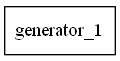

In [31]:
plot_model(generator, show_shapes=True)

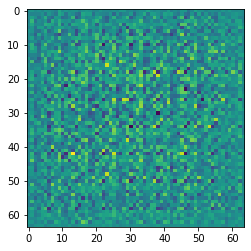

In [35]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [40]:
generated_image.shape

TensorShape([1, 64, 64, 3])

In [ ]:
def make_discriminator_model():
    filters = 64
    model = tf.keras.Sequential([])
    
    
    # 卷积-BN-激活函数:(b, 31, 31, 64)  (64 - 4 + 1) / 2 向上取整
    model.add(layers.Conv2D(filters=filters * 1, kernel_size=4, strides=2, padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 卷积-BN-激活函数:(b, 14, 14, 128)
    model.add(layers.Conv2D(filters=filters * 2, kernel_size=4, strides=2, padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 卷积-BN-激活函数:(b, 6, 6, 256)
    model.add(layers.Conv2D(filters=filters * 4, kernel_size=4, strides=2, padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    
    # 卷积-BN-激活函数:(b, 4, 4, 512)
    model.add(layers.Conv2D(filters=filters * 8, kernel_size=3, strides=1, padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    # 卷积-BN-激活函数:(b, 2, 2, 1024)
    model.add(layers.Conv2D(filters=filters * 16, kernel_size=3, strides=1, padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # (b, 1024)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # logits 输出

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.build(input_shape=(4, 64, 64, 3))

In [ ]:
# 判别器和生成器的损失
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    # real 越接近1越好
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # fake 越接近0越好
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return tf.reduce_mean(total_loss)

def generator_loss(fake_output):
    # 生成的数据结果越接近1越好
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return tf.reduce_mean(loss)